# Concrete Strength
This is a study on concrete strength with Keras model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as t
import os
import sys
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
import keras_tuner as kt

Num GPUs Available:  1


In [2]:
# Read data
df = pd.read_csv('concrete_data.csv')
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [42]:
# select x and y
x = df[['Cement','Blast Furnace Slag','Fly Ash','Water','Superplasticizer','Coarse Aggregate','Fine Aggregate']]
y = df['Strength']

# normalize x and take log of y
x = (x - x.mean()) / x.std()
y = np.log(y)

# train test and validation split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

In [12]:
# define model with hyperparameters
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('layers', min_value=2, max_value=6)):
        model.add(Dense(hp.Int(f'dense_{i}', min_value=10, max_value=100), 
                  activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3))
    return model

In [13]:
# built tuner
tuner = kt.tuners.Hyperband(hypermodel=build_model,
                            objective='val_loss',
                            max_epochs=20,
                            executions_per_trial=3,
                            directory='hp_tune',
                            overwrite=True)

tuner.search_space_summary()               

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': None}
dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': None}


In [15]:
# start searching
tuner.search(x_train,
             y_train,
             epochs=5,
             validation_data=(x_val, y_val),
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Trial 31 Complete [00h 00m 12s]
val_loss: 0.18109764158725739

Best val_loss So Far: 0.1784623662630717
Total elapsed time: 00h 03m 07s
INFO:tensorflow:Oracle triggered exit


In [22]:
# print best model
best_model = tuner.get_best_models(1)[0]

In [23]:
best_model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)])

Epoch 1/100
23/23 [==============================] - 1s 8ms/step - loss: 0.1637 - val_loss: 0.1696
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1553 - val_loss: 0.2075
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1576 - val_loss: 0.1738
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1495 - val_loss: 0.1743
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1494 - val_loss: 0.1743
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1525 - val_loss: 0.1741
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1458 - val_loss: 0.1828
Epoch 8/100
23/23 [==============================] - 0s 5ms/step - loss: 0.1497 - val_loss: 0.1838
Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1456 - val_loss: 0.1734
Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1484 - val_loss: 0.1709
Epoch 11/

In [52]:
# show structure of best model
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 94)                2914      
_________________________________________________________________
dense_2 (Dense)              (None, 74)                7030      
_________________________________________________________________
dense_3 (Dense)              (None, 23)                1725      
_________________________________________________________________
dense_4 (Dense)              (None, 75)                1800      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 76        
Total params: 13,785
Trainable params: 13,785
Non-trainable params: 0
____________________________________________________

In [43]:
# evaluate model
y_pred = best_model.predict(x_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

In [44]:
# convert y_test to np array
y_test = y_test.values

In [46]:
# report result of the model
from sklearn.metrics import mean_squared_error, r2_score
print("MSE: ", mean_squared_error(y_test, y_pred))
print("R2: ", r2_score(y_test, y_pred))

MSE:  156.32492324153395
R2:  0.44731690152947556


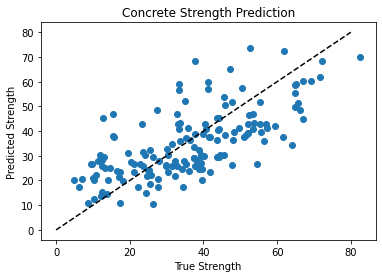

In [51]:
# plot result
plt.scatter(y_test, y_pred)
plt.plot([0, 80], [0, 80], 'k--')
plt.xlabel('True Strength')
plt.ylabel('Predicted Strength')
plt.title('Concrete Strength Prediction')
plt.show()